In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from scipy.signal import correlate
import pandas as pd
from gmeasure import GMeasure
from scipy.interpolate import griddata
from matplotlib.ticker import FuncFormatter, FixedLocator, NullFormatter

In [8]:
def set_log_ticks(ax, axis, vmin, vmax):
    """
    Axis is already in log-space.
    This formats major ticks as 10^n and adds unlabeled minor ticks.
    """

    # Integer powers within range
    pmin = int(np.floor(vmin))
    pmax = int(np.ceil(vmax))
    major_locs = np.arange(pmin, pmax + 1)

    # Major ticks
    formatter = FuncFormatter(lambda x, _: rf"$10^{{{int(x)}}}$")
    locator = FixedLocator(major_locs)

    # Minor ticks: 2–9 within each decade
    minor_locs = []
    for p in range(pmin, pmax):
        minor_locs.extend(p + np.log10(np.arange(2, 10)))

    if axis == "x":
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_minor_locator(FixedLocator(minor_locs))
        ax.xaxis.set_minor_formatter(NullFormatter())

    elif axis == "y":
        ax.yaxis.set_major_locator(locator)
        ax.yaxis.set_major_formatter(formatter)
        ax.yaxis.set_minor_locator(FixedLocator(minor_locs))
        ax.yaxis.set_minor_formatter(NullFormatter())


In [9]:
def plot_gain_surface_frame(
    X1_fine_grid,
    X2_fine_grid,
    gain_surf_fine,
    X1_grid,
    X2_grid,
    gain_exp,
    gain_theo,
    elev,
    azim,
    frame_path
):
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["mathtext.fontset"] = "stix"

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)

    # Surface
    ax.plot_surface(
        X1_fine_grid, X2_fine_grid, gain_surf_fine,
        alpha=0.35, color="grey"
    )

    # Experimental points
    ax.scatter(X1_grid, X2_grid, gain_exp, s=25, c="k")

    # Vertical dashed lines
    for i in range(X1_grid.shape[0]):
        for j in range(X1_grid.shape[1]):
            ax.plot(
                [X1_grid[i, j], X1_grid[i, j]],
                [X2_grid[i, j], X2_grid[i, j]],
                [gain_exp[i, j], gain_theo[i, j]],
                "k--",
                linewidth=0.9,
                alpha=0.9
            )

    # Labels
    ax.set_xlabel(r"$1/\mathrm{C_{p}}\ (\mu\mathrm{F})^{-1}$", fontsize=22, labelpad=15)
    ax.set_ylabel(r"$1/\mathrm{C_{pp}}\ (\mu\mathrm{F})^{-1}$", fontsize=22, labelpad=20)
    ax.set_zlabel("Gain", fontsize=22, labelpad=25)

    ax.tick_params(axis="both", which="major", labelsize=18, length=6)
    ax.tick_params(axis="both", which="minor", length=3)

    # Log-style ticks (your existing function)
    set_log_ticks(ax, "x", X1_grid.min(), X1_grid.max())
    set_log_ticks(ax, "y", X2_grid.min(), X2_grid.max())

    ax.view_init(elev=elev, azim=azim)

    plt.savefig(frame_path, dpi=150)
    plt.close(fig)


In [10]:
import imageio
import os

def make_gain_surface_gif(
    X1_fine_grid,
    X2_fine_grid,
    gain_surf_fine,
    X1_grid,
    X2_grid,
    gain_exp,
    gain_theo,
    elev=30,
    azim_start=0,
    azim_end=360,
    azim_step=3,
    fps=15,
    gif_name="gain_surface_rotation.gif",
    tmp_dir="_frames"
):
    os.makedirs(tmp_dir, exist_ok=True)

    frame_paths = []
    azimuths = np.arange(azim_start, azim_end, azim_step)

    for k, azim in enumerate(azimuths):
        frame_path = os.path.join(tmp_dir, f"frame_{k:04d}.png")

        plot_gain_surface_frame(
            X1_fine_grid,
            X2_fine_grid,
            gain_surf_fine,
            X1_grid,
            X2_grid,
            gain_exp,
            gain_theo,
            elev,
            azim,
            frame_path
        )

        frame_paths.append(frame_path)

    # Assemble GIF
    with imageio.get_writer(gif_name, mode="I", fps=fps) as writer:
        for path in frame_paths:
            writer.append_data(imageio.imread(path))

    print(f"GIF saved as: {gif_name}")


In [11]:

# ============================================================
# Fixed component values (modify as needed)
# ============================================================
# First parallel RLC (at V1)
R1 = 100.864
L1 = 106.4e-3
C1 = 0.2196e-6

# Second parallel RLC (at V2)
R2 = 101.529
L2 = 107.1e-3
C2 = 0.2253e-6

# Third parallel RLC (at V3)
R3 = 101.457
L3 = 107.2e-3
C3 = 0.2306e-6

# ============================================================
# Impedances
# ============================================================
def Z_R(R): return R
def Z_L(w, L): return 1j * w * L
def Z_C(w, C): return 1 / (1j * w * C)

def parallel(a, b):
    return 1 / (1/a + 1/b)

# ============================================================
# Gain formula for asymmetric case
# ============================================================
def compute_gain(w, Cp, Cpp): # Cp = C', Cpp = C''
    # Parallel RLCs
    Z1 = 1 / (1/R1 + 1/Z_L(w, L1) + 1/Z_C(w, C1))
    Z2 = 1 / (1/R2 + 1/Z_L(w, L2) + 1/Z_C(w, C2))
    Z3 = 1 / (1/R3 + 1/Z_L(w, L3) + 1/Z_C(w, C3))

    # Y = Z2 || (Z3 + 1/(jω C''))
    Y = parallel(Z2, Z3 + Z_C(w, Cpp))

    # Gain = Z3/(1/(jω C'') + Z3) * Y/(1/(jω C') + Y)
    G = ( Z3 / (Z3 + Z_C(w, Cpp)) ) * ( Y / (Y + Z_C(w, Cp)) )

    return np.abs(G)



In [12]:
def classify_region(c_value, weak_range, medium_range):
    if weak_range[0] <= c_value <= weak_range[1]:
        return "weak"
    elif medium_range[0] <= c_value <= medium_range[1]:
        return "medium"
    else:
        return "strong"

def analyze_gain_surface(
    data,
    gain_func,
    freq,
    use_inverse=True,
    use_log=True,          # <-- NEW BOOLEAN
    Nsurf=80
):
    # ----------------------------------------------------
    # 1. Extract data
    # ----------------------------------------------------
    C1_vals = np.array(data["C1_values"])     # µF
    C2_vals = np.array(data["C2_values"])     # µF
    gain_exp = np.array(data["gain_amp_matrix"])

    C1_F = C1_vals * 1e-6
    C2_F = C2_vals * 1e-6

    X1 = 1.0 / C1_F if use_inverse else C1_F
    X2 = 1.0 / C2_F if use_inverse else C2_F

    # ----------------------------------------------------
    # 2. Coordinate space (log or linear)
    # ----------------------------------------------------
    if use_log:
        X1_plot = np.log10(X1)
        X2_plot = np.log10(X2)
    else:
        X1_plot = X1
        X2_plot = X2

    X1_grid, X2_grid = np.meshgrid(X1_plot, X2_plot, indexing="ij")

    # ----------------------------------------------------
    # 3. Compute theoretical gain
    # ----------------------------------------------------
    w = 2 * np.pi * freq
    gain_theo = np.zeros_like(gain_exp)

    for i in range(len(C1_F)):
        for j in range(len(C2_F)):
            gain_theo[i, j] = gain_func(w, C1_F[i], C2_F[j])

    # ----------------------------------------------------
    # 4. Fine surface
    # ----------------------------------------------------
    X1_fine = np.linspace(X1_plot.min(), X1_plot.max(), Nsurf)
    X2_fine = np.linspace(X2_plot.min(), X2_plot.max(), Nsurf)
    X1_fine_grid, X2_fine_grid = np.meshgrid(X1_fine, X2_fine, indexing="ij")

    points = np.column_stack([X1_grid.flatten(), X2_grid.flatten()])
    values = gain_theo.flatten()

    gain_surf_fine = griddata(
        points, values,
        (X1_fine_grid, X2_fine_grid),
        method="cubic"
    )

    # ----------------------------------------------------
    # 5. Stats
    # ----------------------------------------------------
    def compute_stats(z_true, z_pred):
        ss_res = np.sum((z_true - z_pred) ** 2)
        ss_tot = np.sum((z_true - np.mean(z_true)) ** 2)
        R2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
        RMSE = np.sqrt(ss_res / len(z_true))
        MAE = np.mean(np.abs(z_true - z_pred))
        mask = z_true != 0
        MAPE = (
            np.mean(np.abs((z_true[mask] - z_pred[mask]) / z_true[mask])) * 100
            if np.any(mask) else np.nan
        )
        return {"R2": R2, "RMSE": RMSE, "MAE": MAE, "MAPE": MAPE}

    full_stats = compute_stats(gain_exp.flatten(), gain_theo.flatten())

    # ----------------------------------------------------
    # 6. Region stats
    # ----------------------------------------------------
    weak_range   = (1.022, 9.822)
    medium_range = (0.02236, 0.2266)

    C1_labels = [classify_region(c, weak_range, medium_range) for c in C1_vals]
    C2_labels = [classify_region(c, weak_range, medium_range) for c in C2_vals]

    region_stats = {}

    for i, l1 in enumerate(C1_labels):
        for j, l2 in enumerate(C2_labels):
            key = (l1, l2)
            if key not in region_stats:
                region_stats[key] = {"z_true": [], "z_pred": []}

            region_stats[key]["z_true"].append(gain_exp[i, j])
            region_stats[key]["z_pred"].append(gain_theo[i, j])

    for key in region_stats:
        z_true = np.array(region_stats[key]["z_true"])
        z_pred = np.array(region_stats[key]["z_pred"])
        region_stats[key] = compute_stats(z_true, z_pred)

    # ----------------------------------------------------
    # 7. 3D plots (multiple angles)
    # ----------------------------------------------------
    viewing_angles = [(30, 75)]

    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["mathtext.fontset"] = "stix"

    LOG_MICRO_SHIFT = np.log10(1e6)   # = 6

    X1_grid = X1_grid - LOG_MICRO_SHIFT
    X2_grid = X2_grid - LOG_MICRO_SHIFT

    X1_fine_grid = X1_fine_grid - LOG_MICRO_SHIFT
    X2_fine_grid = X2_fine_grid - LOG_MICRO_SHIFT

    for elev, azim in viewing_angles:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection="3d")
        fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)

        ax.plot_surface(
            X1_fine_grid, X2_fine_grid, gain_surf_fine,
            alpha=0.35, color="grey"
        )

        ax.scatter(X1_grid, X2_grid, gain_exp, s=25, c="k")

                # ---- Vertical lines from data points to theoretical surface ----
        for i in range(X1_grid.shape[0]):
            for j in range(X1_grid.shape[1]):
                x = X1_grid[i, j]
                y = X2_grid[i, j]
                z_exp = gain_exp[i, j]
                z_theo = gain_theo[i, j]

                ax.plot(
                    [x, x],
                    [y, y],
                    [z_exp, z_theo],
                    "k--",
                    linewidth=0.9,
                    alpha=0.9,
                )

        # ---- Axis labels (PHYSICAL variables, not log) ----
        ax.set_xlabel(r"$1/\mathrm{C_{p}}\ (\mu\mathrm{F})^{-1}$", fontsize=22, labelpad= 15)
        ax.set_ylabel(r"$1/\mathrm{C_{pp}}\ (\mu\mathrm{F})^{-1}$", fontsize=22, labelpad= 20)
        ax.set_zlabel("Gain", fontsize=22, labelpad= 25)

        ax.tick_params(axis="both", which="major", labelsize=18, length=6, size = 12)
        ax.tick_params(axis="y", which="major", labelsize=18, length=6, size = 12, pad = 10)
        ax.tick_params(axis="z", which="major", labelsize=18, length=6, size = 12, pad = 10)
        ax.tick_params(axis="both", which="minor", length=3)

        # ---- Log-style ticks ----
        set_log_ticks(ax, "x", X1_grid.min(), X1_grid.max())
        set_log_ticks(ax, "y", X2_grid.min(), X2_grid.max())

        

        ax.view_init(elev=elev, azim=azim)
        plt.savefig("Gain_Surface_C1_C2_prime.pdf")
        plt.show()

    make_gain_surface_gif(
    X1_fine_grid=X1_fine_grid,
    X2_fine_grid=X2_fine_grid,
    gain_surf_fine=gain_surf_fine,
    X1_grid=X1_grid,
    X2_grid=X2_grid,
    gain_exp=gain_exp,
    gain_theo=gain_theo,
    elev=30,
    azim_start=0,
    azim_end=360,
    azim_step=2,
    fps=20,
    gif_name="Gain_Surface_C1_C2_rotation.gif"
    )
    # ----------------------------------------------------
    # 8. Return
    # ----------------------------------------------------
    return {
        "full_stats": full_stats,
        "region_stats": region_stats,
        "X1": X1_plot,
        "X2": X2_plot,
        "gain_theoretical": gain_theo
    }


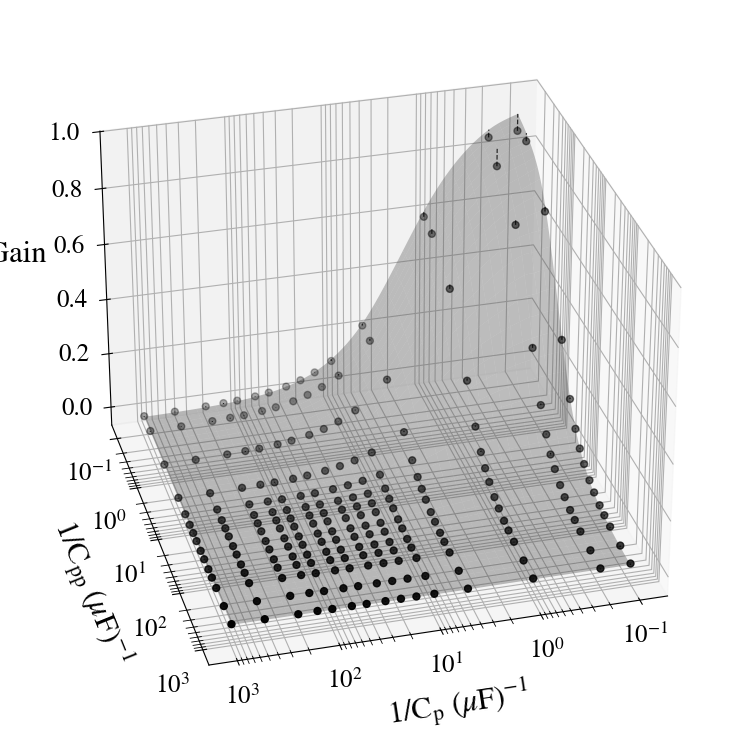

/tmp/ipykernel_6662/2875751879.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(path))


GIF saved as: Gain_Surface_C1_C2_rotation.gif

==================== FULL SURFACE R² ====================
R²: 0.9974712346485064

==================== REGION R² VALUES ====================
Region C1=weak, C2=weak: R² = 0.6447138383119554
Region C1=weak, C2=medium: R² = 0.9972844682092834
Region C1=weak, C2=strong: R² = 0.916611199161501
Region C1=medium, C2=weak: R² = 0.9961432547290274
Region C1=medium, C2=medium: R² = 0.9969038488238074
Region C1=medium, C2=strong: R² = 0.510969503583337
Region C1=strong, C2=weak: R² = 0.9985062529273855
Region C1=strong, C2=medium: R² = 0.9971218400005335
Region C1=strong, C2=strong: R² = 0.7388079990205745


In [13]:
# -------------------------------------------------------------
# USAGE EXAMPLE
# -------------------------------------------------------------
data = np.load("cap_sweep_data.npz", allow_pickle=True)

freq = 5000  # Hz

results = analyze_gain_surface(
    data=data,
    gain_func=compute_gain,
    freq=freq,
    use_inverse=True,
    use_log= True
)

# -------------------------------------------------------------
# PRINT FULL-SURFACE R²
# -------------------------------------------------------------
print("\n==================== FULL SURFACE R² ====================")
print(f"R²: {results['full_stats']['R2']}")

# -------------------------------------------------------------
# PRINT REGION R² (9 REGIONS)
# -------------------------------------------------------------
print("\n==================== REGION R² VALUES ====================")

region_stats = results["region_stats"]
region_order = ["weak", "medium", "strong"]

for r1 in region_order:
    for r2 in region_order:
        key = (r1, r2)
        stats = region_stats.get(key)
        if stats is None:
            continue

        print(f"Region C1={r1}, C2={r2}: R² = {stats['R2']}")


In [8]:
# -------------------------------------------------------------
# Build 3×3 R² matrix (weak / medium / strong)
# -------------------------------------------------------------
region_order = ["weak", "medium", "strong"]
region_stats = results["region_stats"]

R2_matrix = np.zeros((3, 3))
R2_matrix[:] = np.nan

for i, r1 in enumerate(region_order):
    for j, r2 in enumerate(region_order):
        key = (r1, r2)
        if key in region_stats:
            R2_matrix[i, j] = region_stats[key]["R2"]

# -------------------------------------------------------------
# Print matrix
# -------------------------------------------------------------
print("\n==================== R² MATRIX ====================")
print("Rows = C1 region  (weak, medium, strong)")
print("Cols = C2 region  (weak, medium, strong)\n")
print(R2_matrix)



==================== R² MATRIX ====================
Rows = C1 region  (weak, medium, strong)
Cols = C2 region  (weak, medium, strong)

[[0.64471384 0.99728447 0.9166112 ]
 [0.99614325 0.99690385 0.5109695 ]
 [0.99850625 0.99712184 0.738808  ]]


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def analyze_gain_heatmap(
    data,
    use_inverse=True,
    Nsurf=250,
    cmap="viridis",
    n_contours=12,
    C_min=None          # <-- NEW: minimum capacitance (µF)
):
    # ----------------------------------------------------
    # 1. Extract experimental data
    # ----------------------------------------------------
    C1_vals = np.array(data["C1_values"])      # µF
    C2_vals = np.array(data["C2_values"])      # µF
    gain_exp = np.array(data["gain_amp_matrix"])

    C1_F = C1_vals
    C2_F = C2_vals 

    X1 = 1.0 / C1_F if use_inverse else C1_F
    X2 = 1.0 / C2_F if use_inverse else C2_F

    # ----------------------------------------------------
    # 2. Coordinate space (log)
    # ----------------------------------------------------
    X1_plot = np.log10(X1)
    X2_plot = np.log10(X2)

    X1_grid, X2_grid = np.meshgrid(X1_plot, X2_plot, indexing="ij")

    # ----------------------------------------------------
    # 3. Fine grid for interpolation
    # ----------------------------------------------------
    X1_fine = np.linspace(X1_plot.min(), X1_plot.max(), Nsurf)
    X2_fine = np.linspace(X2_plot.min(), X2_plot.max(), Nsurf)

    X1_fine_grid, X2_fine_grid = np.meshgrid(X1_fine, X2_fine, indexing="ij")

    points = np.column_stack([
        X1_grid.flatten(),
        X2_grid.flatten()
    ])
    values = gain_exp.flatten()

    gain_interp = griddata(
        points, values,
        (X1_fine_grid, X2_fine_grid),
        method="cubic"
    )

    # Fill NaNs
    mask = np.isnan(gain_interp)
    if np.any(mask):
        gain_interp[mask] = griddata(
            points, values,
            (X1_fine_grid[mask], X2_fine_grid[mask]),
            method="linear"
        )

    # ----------------------------------------------------
    # 4. Undo log for plotting
    # ----------------------------------------------------
    X1_plot_fine = 10**X1_fine_grid
    X2_plot_fine = 10**X2_fine_grid

    # ----------------------------------------------------
    # 5. Apply capacitance lower bound
    # ----------------------------------------------------
    if C_min is not None:
        if use_inverse:
            X_max = 1.0 / C_min    # max inverse capacitance
            valid = (X1_plot_fine <= X_max) & (X2_plot_fine <= X_max)
        else:
            valid = (X1_plot_fine >= C_min) & (X2_plot_fine >= C_min)

        gain_interp = np.ma.masked_where(~valid, gain_interp)

    # ----------------------------------------------------
    # 6. Plot heat map + contours
    # ----------------------------------------------------
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["mathtext.fontset"] = "stix"

    fig, ax = plt.subplots(figsize=(10, 7.5))

    pcm = ax.pcolormesh(
        X1_plot_fine,
        X2_plot_fine,
        gain_interp,
        shading="auto",
        cmap=cmap
    )

    cs = ax.contour(
        X1_plot_fine,
        X2_plot_fine,
        gain_interp,
        levels=n_contours,
        colors="k",
        linewidths=1.0
    )
    # ----------------------------------------------------
    # 6.5 Axis limits from capacitance cutoff
    # ----------------------------------------------------
    if C_min is not None:
        if use_inverse:
            X_max = 1.0 / C_min

            # lower limit = smallest value in grid
            x_min = X1_plot_fine.min()
            y_min = X2_plot_fine.min()

            # inverted axes → (max, min)
            ax.set_xlim(X_max, x_min)
            ax.set_ylim(X_max, y_min)

        else:
            x_max = X1_plot_fine.max()
            y_max = X2_plot_fine.max()

            ax.set_xlim(C_min, x_max)
            ax.set_ylim(C_min, y_max)

    # ----------------------------------------------------
    # 7. Axis handling
    # ----------------------------------------------------
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlabel(r"$1/\mathrm{C_{p}}\ (\mu\mathrm{F})^{-1}$", fontsize=23)
    ax.set_ylabel(r"$1/\mathrm{C_{pp}}\ (\mu\mathrm{F})^{-1}$", fontsize=23)

    # ----------------------------------------------------
    # 8. Colorbar
    # ----------------------------------------------------
    cbar = fig.colorbar(pcm, ax=ax, pad=0.02)
    cbar.set_label("Gain", fontsize=23)
    cbar.ax.tick_params(labelsize=18)

    ax.tick_params(axis="both", which="major", labelsize=19, length=6)
    ax.tick_params(axis="both", which="minor", length=3)

    plt.tight_layout()
    plt.savefig("Interpolated_Heatmap.pdf")
    plt.show()

    return {
        "X1_fine": X1_fine,
        "X2_fine": X2_fine,
        "gain_interpolated": gain_interp
    }


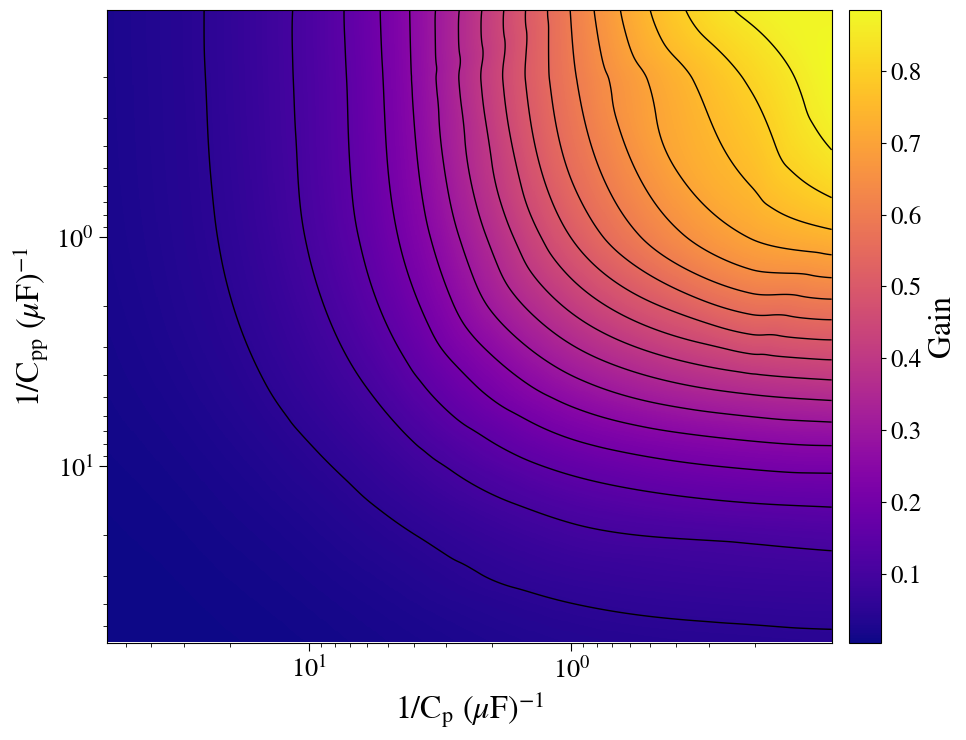

In [53]:
result = analyze_gain_heatmap(
    data=data,
    use_inverse=True,
    Nsurf=1000,
    cmap="plasma",
    n_contours=20,
    C_min= 0.017
)